In [31]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx

import numpy as np

import gurobipy as gp
from gurobipy import GRB

from itertools import combinations

import time as trun

In [32]:
def is_subclique(G, nodelist):
    '''
    For each pair of nodes in nodelist whether there is an edge
    if any edge is missing, we know that it's not a subclique.
    if all edges are there, it is a subclique
    '''
    for (u,v) in combinations(nodelist,2):  #check each possible pair
        if not G.has_edge(u,v):
            return False #if any edge is missing we're done
    return True  #if we get to here, then every edge was there.  It's True.


In [43]:
#instance

#inst_="internet_graph"
#dim_=75
#id_=1
#instance_=f"{inst_}_{dim_}_{id_}"
#G = nx.read_gml(f"../instances/{inst_}/{dim_}/{instance_}.gml.gz",destringizer=int)

inst_="karate"
instance_=f"{inst_}"
G = nx.read_gml(f"../instances/{inst_}/{instance_}.gml.gz",destringizer=int)

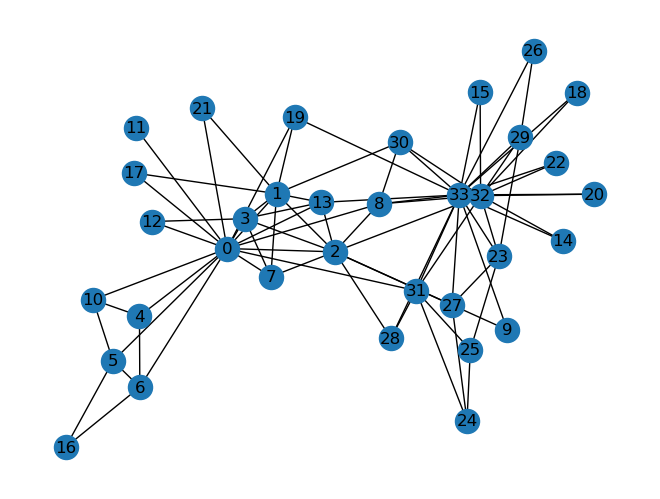

In [44]:
nx.draw(G,  with_labels = True)

In [45]:
nx.is_connected(G)

True

In [46]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

dm = np.zeros((N,N), dtype=int)

p = nx.shortest_path(G)

for i in range(0,N):
    for j in range(0,N):
        dm[i][j] = len(p[i][j])-1

In [47]:
#for i in G:
#    Ni = nx.neighbors(G,i)
#
#    nodelist = []
#    for k in Ni:
#        nodelist.append(k)
#    
#    if(is_subclique(G, nodelist)):
#        print("vizinhanca de %d" %i)

In [54]:
form_="fmin"
method_="mip"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)
status = np.zeros((N), dtype=float)

con_geo = 0
con_neighb = 0
con_miset_neighb = 1

#result_path = Path('../result/')

for i in G:

    Ni = nx.neighbors(G,i)

    listNi = []
    for k in Ni:
        listNi.append(k)

    tstart = trun.time()
    status_clique = is_subclique(G, listNi)
    tend = trun.time()

    elapsed_time = tend - tstart
    
    if(status_clique):
        #print("tukey[%d] = 1" %i)
        lb[i] = 1
        ub[i] = 1
        gap[i] = 0.0
        time[i] = elapsed_time
        nodes[i] = 0
        status[i] = 1

    else:

        model = gp.Model(f"{instance_}")

        if (method_=="mip"):
            x = model.addVars(N, vtype=GRB.BINARY, name="x")
        else:
            x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
    
        obj = 0
        for j in G:
            obj += 1 * x[j]
         
        model.setObjective(obj, GRB.MINIMIZE)
    
        # configurando parametros
        # model.Params.TimeLimit = 60
        model.Params.MIPGap = 1.e-6
        model.Params.Threads = 1
        # model.Params.Presolve = 0
        # model.Params.Cuts = 0
 
        # Turn off display and heuristics
        gp.setParam('OutputFlag', 0)
        gp.setParam('Heuristics', 0)

        model.addConstr(x[i] == 1, "fix_x")

        # geodesic
        if con_geo == 1:
            for u in range(0,N):
                for w in range(u+1,N):
                    #if dm[u,w] <= N:
                    for s in range(0,N):
                        if (s != u) and (s != w):
                            if (dm[u,s] + dm[s,w] == dm[u,w]):
                                model.addConstr(x[u] + x[w] >= x[s], "geodesic")

        # geodesic neighbors
        if con_neighb == 1:
            for u in range(0,N):
                Nu = nx.neighbors(G,u)
            
                listNu = []
                for j in Nu:
                    listNu.append(j)

                for w in range(u+1,N):
                    if (w != u) and (w not in listNu):
                        for s in listNu:
                            if (s != w) and (dm[u,s] + dm[s,w] == dm[u,w]):
                                model.addConstr(x[u] + x[w] >= x[s], "geodesic_neighb")


        if con_miset_neighb == 1:
            # maximal independent set
            for u in range(0,N):
                Nu = nx.neighbors(G,u)
            
                listNu = []
                for k in Nu:
                    listNu.append(k)

                T = nx.Graph()
                T.add_nodes_from(listNu)
                for (a,b) in combinations(listNu,2):
                    if G.has_edge(a,b):
                        T.add_edge(a,b)

                #nx.draw(T,  with_labels = True)

                Im = nx.maximal_independent_set(T)

                if (len(Im) > 0):
                    constr = 0
                    for k in Im:
                        constr += 1 * x[k]
                    model.addConstr(constr >= (len(Im)- 1)*x[u], "miset_new")

                T.clear()

            # geodesic miset neighb 
            for u in range(0,N):
                Nu = nx.neighbors(G,u)
            
                listNu = []
                for j in Nu:
                    listNu.append(j)

                for w in range(u+1,N):
                    if (w != u) and (w not in listNu):
                        for s in listNu:
                            if (s != w) and (dm[u,s] + dm[s,w] == dm[u,w]) and (dm[u,w] >= 3):
                                model.addConstr(x[u] + x[w] >= x[s], "geodesic_miset_neighb")

        #model.write(f"{instance_}.lp")

        model.optimize()

        tmp = 0
        if model.status == GRB.OPTIMAL:
            tmp = 1
    
        if (method_=="mip"):
            lb[i] = model.objBound
            ub[i] = model.objVal
            gap[i] = model.MIPGap
            time[i] = model.Runtime
            nodes[i] = model.NodeCount
            status[i] = tmp
        else:
            ub[i] = model.objVal
            time[i] = model.Runtime
            status[i] = tmp

        model.dispose()

In [55]:
tksum = np.sum(ub)
tkmax = np.max(ub)
tktime = np.sum(time)

In [56]:
if method_ == "lp":
    for i in G:
        print("vertice:%d, ub: %.2f, time: %.2f " % (i, ub[i], time[i]))

    print("tksum : %.2f" %(tksum))
    print("tkmax : %.2f" %(tkmax))
    print("tktime : %.2f" %(tktime))

if method_ == "mip":
    for i in G:
        print(
            "vertice:%d, lb: %d, ub: %d, gap: %.2f, time: %.2f, nodes: %d, status: %d " 
            % (i, lb[i], ub[i], gap[i], time[i], nodes[i], status[i])
            )

    print("tksum : %.2f" %(tksum))
    print("tkmax : %.2f" %(tkmax))
    print("tktime : %.2f" %(tktime))

#G.clear()

vertice:0, lb: 19, ub: 19, gap: 0.00, time: 0.01, nodes: 1, status: 1 
vertice:1, lb: 5, ub: 5, gap: 0.00, time: 0.00, nodes: 1, status: 1 
vertice:2, lb: 15, ub: 15, gap: 0.00, time: 0.00, nodes: 1, status: 1 
vertice:3, lb: 3, ub: 3, gap: 0.00, time: 0.00, nodes: 1, status: 1 
vertice:4, lb: 2, ub: 2, gap: 0.00, time: 0.00, nodes: 1, status: 1 
vertice:5, lb: 2, ub: 2, gap: 0.00, time: 0.00, nodes: 1, status: 1 
vertice:6, lb: 3, ub: 3, gap: 0.00, time: 0.00, nodes: 1, status: 1 
vertice:7, lb: 1, ub: 1, gap: 0.00, time: 0.00, nodes: 0, status: 1 
vertice:8, lb: 17, ub: 17, gap: 0.00, time: 0.04, nodes: 3, status: 1 
vertice:9, lb: 16, ub: 16, gap: 0.00, time: 0.05, nodes: 5, status: 1 
vertice:10, lb: 1, ub: 1, gap: 0.00, time: 0.00, nodes: 1, status: 1 
vertice:11, lb: 1, ub: 1, gap: 0.00, time: 0.00, nodes: 0, status: 1 
vertice:12, lb: 1, ub: 1, gap: 0.00, time: 0.00, nodes: 0, status: 1 
vertice:13, lb: 13, ub: 13, gap: 0.00, time: 0.00, nodes: 1, status: 1 
vertice:14, lb: 1, u